# Kaggle Houseprice —— 回归问题的常见解法

Houseprice和Titanic一样，是Kaggle中的入门比赛，旨在帮助初学者熟悉回归问题的处理方式。

比赛内容也很简单：通过房屋的特征预测房价，也就是一个房产评估的问题。

国内的房产评估涉及到学区、土地级别、周边基价、房屋周边医疗商业等配套等一系列因素，这些因素在这个数据集里面以分区级别（MSZoning)、街道类别（Street）等体现，当然，学区是没有的。

外国人买房子主要考虑什么呢？我们先看一下Kaggle给的数据集包括了那些信息(本文只做简单介绍，欲知详情请参看赛事中提供的data_description.txt)：

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


这个比赛我在买房之前曾经做过一次，排名不太好看

现在回头看发现大有玄机，下面讲一下我的思路吧

## 主要特征

数据集中除了繁杂的房屋特征外，值得注意的特征有如下几个：

### Neighborhood

即在城市中所处的片区，同一片区的房屋价格不会有太大差异，所以评估房屋价格时可以参考同区域的价格。

### MoSold

销售月份，每年的房屋价格可能会出现周期性变化，国内的房市有时会有这种规律。

### YrSold

销售年份，不同年份的房屋价格相差巨大，评估时应当以相近年份的房屋作为参考。


下面对这三个特征进行逐个分析

### Neighborhood

In [2]:
train_data.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [3]:
test_data.Neighborhood.value_counts()

NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert     86
Sawyer      77
SawyerW     66
Mitchel     65
NWAmes      58
IDOTRR      56
Crawfor     52
BrkSide     50
Timber      34
NoRidge     30
StoneBr     26
SWISU       23
MeadowV     20
ClearCr     16
NPkVill     14
BrDale      14
Veenker     13
Blmngtn     11
Blueste      8
Name: Neighborhood, dtype: int64

每个区都有测试数据和训练数据，可以将区域均价作为一个特征带入模型

### MoSold

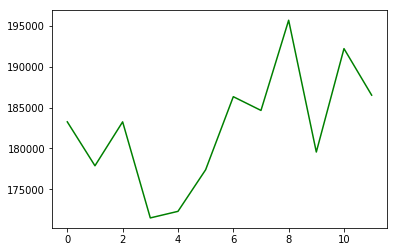

In [4]:
p_month = []
for i in range(1,13):
    p_month.append(train_data[train_data.MoSold == i]['SalePrice'].mean())
plt.plot(p_month,color = 'g')

从图中可以看到各个月份之间的价格相差很大

### YrSold

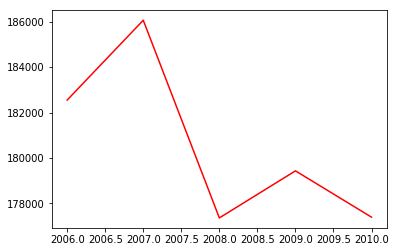

In [5]:
p_year = []
year = set(train_data.YrSold.values)
for y in year:
    p_year.append(train_data[train_data.YrSold == y]['SalePrice'].mean())
plt.plot(list(year),p_year,color = 'r')

### MoSold + YrSold

绘制出每个月的房价变化，可以以时间序列分析来预测当月的全市均价，并借此来辅助房价预测

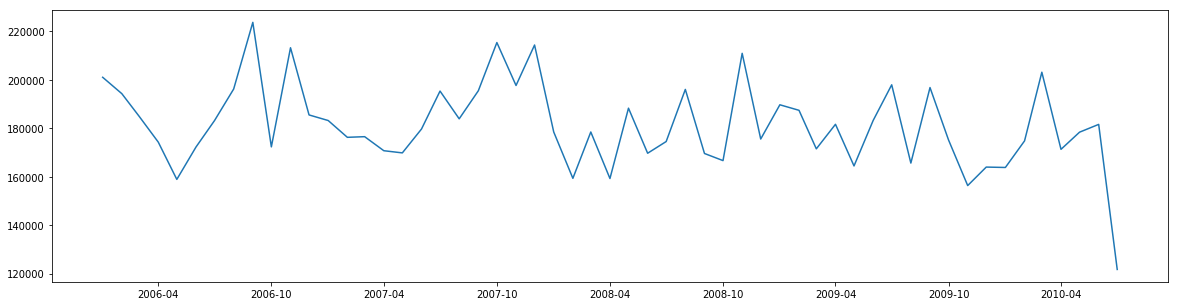

In [6]:
df = pd.DataFrame({
    'year':train_data['YrSold'],
    'month':train_data['MoSold'],
    'day':[1 for i in range(train_data.shape[0])]
})
df_time = pd.to_datetime(df,format='%Y%m')
train_data['SaleTime'] = df_time
train_data = train_data.sort_values(by='SaleTime')
plt.figure(figsize=(20,5))
# plt.plot(train_data['SaleTime'],train_data['SalePrice'],color = 'b')
plt.plot(train_data['SaleTime'],[train_data[train_data['SaleTime']==t]['SalePrice'].mean() for t in train_data['SaleTime']])

在2006年到2009年间，房价高峰都在10月到11月，低谷在4月到5月。

### 添加参考价格

该区域最近交易价格，取五个该区域的最近交易房产的均价作为参考价格，但是Blueste地区只有两个训练数据，所以只能以这两个数据的均价作为参考价格

In [7]:
def reference(df,train_data):
    references = []
    # 使用df.iterrows()遍历速度更快；
    # 但是要注意其中的row是由原df中复制出来的；
    # 对row复制不会影响到df的值
    print(df.shape)
    for i,row in df.iterrows():
        saletime = row['SaleTime']
        region = row['Neighborhood']
        neighbor = train_data[train_data['Neighborhood'] == region]
        if neighbor.shape[0] <= 5:
            reference_price = neighbor['SalePrice'].mean()
            # return reference_price
            references.append(reference_price)
            continue
        
        neighbor['diff_time'] = neighbor['SaleTime'].apply(lambda x: (x-saletime).days)
        neighbor = neighbor.sort_values(by='diff_time')
        reference_price = neighbor[:5]['SalePrice'].mean()
        # return reference_price
        references.append(reference_price)
    print(len(references),df.shape[0])
    df['ReferencePrice'] = references
    return df
train_data = reference(train_data,train_data)
train_data.ReferencePrice.value_counts()

(1460, 82)


H:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1460 1460


158660.0    225
218480.0    150
106300.0    113
116080.0    100
226910.4     86
208080.0     79
282613.8     77
153700.0     74
197560.0     73
164080.0     59
110180.0     58
198900.0     51
153000.0     49
283600.0     41
299080.0     38
105400.0     37
183000.0     28
144100.0     25
383056.0     25
115060.0     17
207806.2     17
98600.0      16
239100.0     11
143700.0      9
137500.0      2
Name: ReferencePrice, dtype: int64

### 处理其他特征

#### 1. 缺失值处理

In [10]:
train_data_na = train_data.isnull().sum()/train_data.shape[0]
train_data_na = train_data_na.drop(train_data_na[train_data_na==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing_Ratio':train_data_na})
missing_data

,Missing_Ratio
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageType,0.055479
GarageFinish,0.055479
GarageQual,0.055479


并非所有的缺失值都是数据丢失，根据data_description.txt描述，部分数据的缺失是代表没有此项特征，如FireplaceQu的缺失代表没有壁炉。

#### 2. 偏态数据处理

因为线性回归中的偏差项为正态分布项，所以在数据符合正态分布时能获得更好的效果。

偏态数据处理包括处理特征x与标签y。对于标签y的偏态处理常常会采用易于还原的处理方式，比如取对数，而对特征x的处理方式就比较自由。

我所知的查看数据分布是否是偏态的方式有如下几种：

##### （1）绘制概率分布图

绘制概率分布图，查看图形是否符合正态分布图形

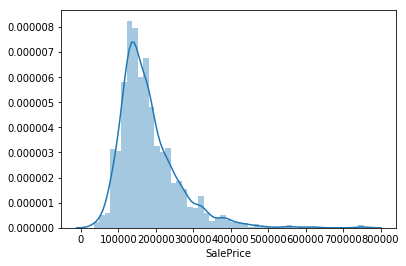

In [13]:
import seaborn as sns
sns.distplot(train_data['SalePrice'])

##### （2） 绘制正态概率图

正态概率图用于检查一组数据是否服从正态分布。是实数与正态分布数据之间函数关系的散点图，如果这组实数服从正态分布，正态概率图将是一条直线

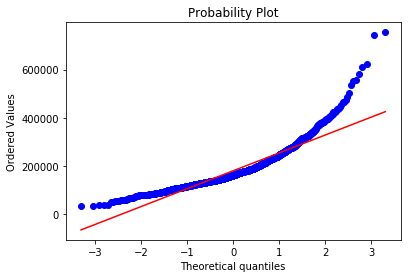

In [18]:
from scipy import stats
res = stats.probplot(train_data['SalePrice'],plot = plt)

##### (3) 计算偏度

使用scipy.stats.skew函数计算数据分布的偏度（也叫偏态系数），正态分布的偏态系数为0

In [21]:
from scipy.stats import skew
ske = skew(train_data['SalePrice'])
ske

1.8809407460340355

以上三个方法都证明了SalePrice为偏态分布，为了在优化模型的同时易于还原真实的SalePrice，我们可以对SalePrice进行对数处理。

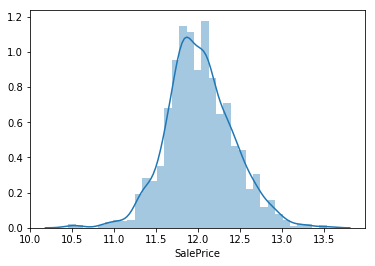

In [27]:
import numpy as np 
y = train_data['SalePrice']
y = np.log(y)
sns.distplot(y)

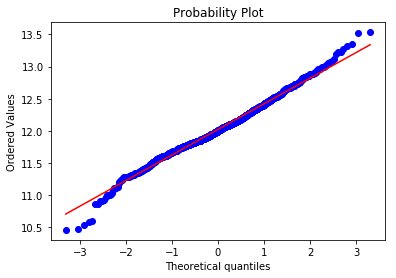

In [29]:
res = stats.probplot(y,plot = plt)

In [31]:
ske = skew(y)
ske

0.12121036730136549

虽然处理之后还不算符合正态分布，但是也比之前的分布状况好的多了。具体的特征工程及模型代码可以参考我的github。